# WSDM Cup - Explainatory Data Analysis + Feature Engineering

In this notebook we get data from the kaggle web site. Those are inputs given to train a model for the competition.  
We are going to clean and shape those data for our usage.  
We might also apply some feature engineering.  
We might also 'augment' those data by adding similar data from another competition.  
Then we save them on csv format. 

In [1]:
import sklearn

import numpy as np 
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split

import ModelsUtils as Utils

f:\Projects\Kaggle\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch as torch

from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.nn.functional import cross_entropy

from transformers import AutoModel, AutoTokenizer

print('Torch version:', torch.__version__)
print('Torch is build with CUDA:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Torch device : {device}')
print('------------------------------')

Torch version: 2.5.1+cu118
Torch is build with CUDA: True
Torch device : cuda
------------------------------


In [3]:
import transformers as trsf
print("Transformers:", trsf.__version__)
print("Pytorch:", torch.__version__)

Transformers: 4.46.3
Pytorch: 2.5.1+cu118


# Config

In [4]:
MINI_RUN = False
sample_size = 0.01      # Only applied if MINI_RUN is t
seed = 707
ORIGINAL = True

----------------------------------------------------------------------

# Files

In [5]:
df_trainO = pd.read_parquet('../Data/Original/wsdm-cup-multilingual-chatbot-arena/train.parquet', engine='pyarrow') # original

In [6]:
df_trainO.head(2)

,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian


load parquet  
do some eda  
languages distribution  
remove row with very low length  
(add data from other project) -> (check for duplicates)  
save csv  

### Merge with other source of data

In [7]:
if ORIGINAL:
    df_train = df_trainO

In [8]:
df_train.shape

(48439, 8)

### Sample

In [9]:
if MINI_RUN:
    df_train = df_train.sample(frac=sample_size, random_state=seed)

### Clean

In [10]:
#df_train["prompt"] = df_train.prompt.map(lambda x: ''.join(eval(x.replace("null","''"))))
#df_train["response_a"] = df_train.response_a.map(lambda x: ''.join(eval(x.replace("null","''"))))
#df_train["response_b"] = df_train.response_b.map(lambda x: ''.join(eval(x.replace("null", "''"))))

In [11]:
#def process_text(text: str) -> str:
#    return "".join(eval(text, {"null": ""}))
#
#df_train.loc[:, 'prompt'] = df_train['prompt'].apply(process_text)
#df_train.loc[:, 'response_a'] = df_train['response_a'].apply(process_text)
#df_train.loc[:, 'response_b'] = df_train['response_b'].apply(process_text)
#
#display(df_train.head(5))

In [12]:
df_train['prompt'] = df_train['prompt'].astype(str)
df_train['response_a'] = df_train['response_a'].astype(str)
df_train['response_b'] = df_train['response_b'].astype(str)

### Force encoding UTF-8

In [13]:
df_train = df_train.apply(Utils.reencode, axis=1)  # Apply the make_pairs function to each row in df

In [14]:
df_train.encode_fail.value_counts(normalize=False)

encode_fail
False    48439
Name: count, dtype: int64

### One Hot

In [15]:
# Label conversion One Hot
df_train["class_label"] = df_train.winner.map(Utils.name2label)

In [16]:
df_train.head()

,id,prompt,response_a,response_b,winner,model_a,model_b,language,encode_fail,class_label
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak,False,0
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian,False,0
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"Dört basamaklı, rakamları birbirinden ve sıfır...","Bu soruyu çözmek için, verilen koşulları adım ...",Bu problemi adım adım çözelim:\n\n1) ABCD - DC...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish,False,0
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 Cabaletta Bio (CABA), Rocket Ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 AI 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English,False,1
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,Please be boring,"Alright, I'll be as boring as possible.\n\nTod...","Understood. Here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English,False,0


### Check Empty

### Duplicates

In [17]:
df_train[df_train.duplicated(['id'], keep=False)]

,id,prompt,response_a,response_b,winner,model_a,model_b,language,encode_fail,class_label


### Minimum length

Maybe better to check minimum number of token instead ?

#### Add length

In [18]:
for col in ["prompt", "response_a", "response_b"]:
    df_train[f"{col}_len"] = df_train[f"{col}"].str.len()

#### Check

In [19]:
for col in ["prompt", "response_a", "response_b"]:
    df_filtered = df_train.loc[df_train[f"{col}_len"] <= 10]

In [20]:
df_filtered.shape[0]

176

----------------------------------------------------------------------

# EDA

In [21]:
sns.set(style='darkgrid')

In [22]:
df_train.shape

(48439, 13)

### Distribution of LLMs

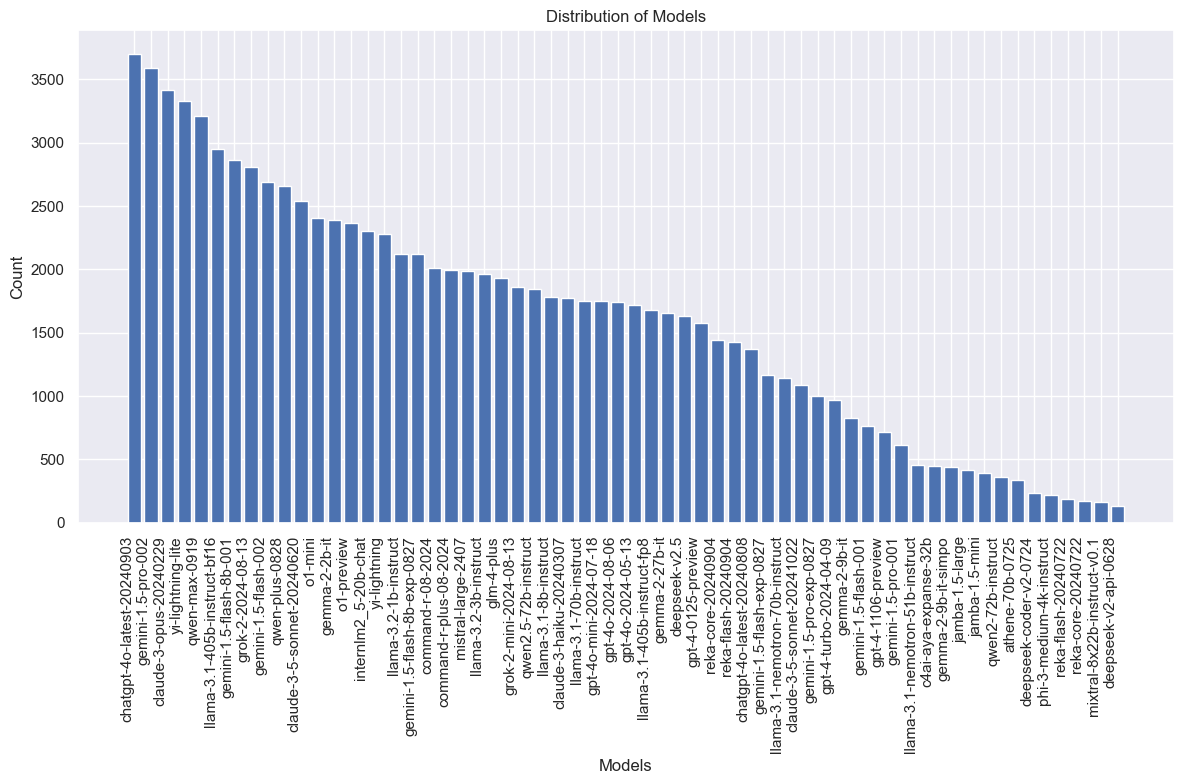

In [23]:
# Count the occurrences of each model in 'model_a'
model_df = pd.concat([df_train.model_a, df_train.model_b])

counts = model_df.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

# Create the bar chart
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plt.bar(counts['LLM'], counts['Count'])
plt.xlabel('Models')
plt.ylabel('Count')
plt.title('Distribution of Models')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Distribution of languages

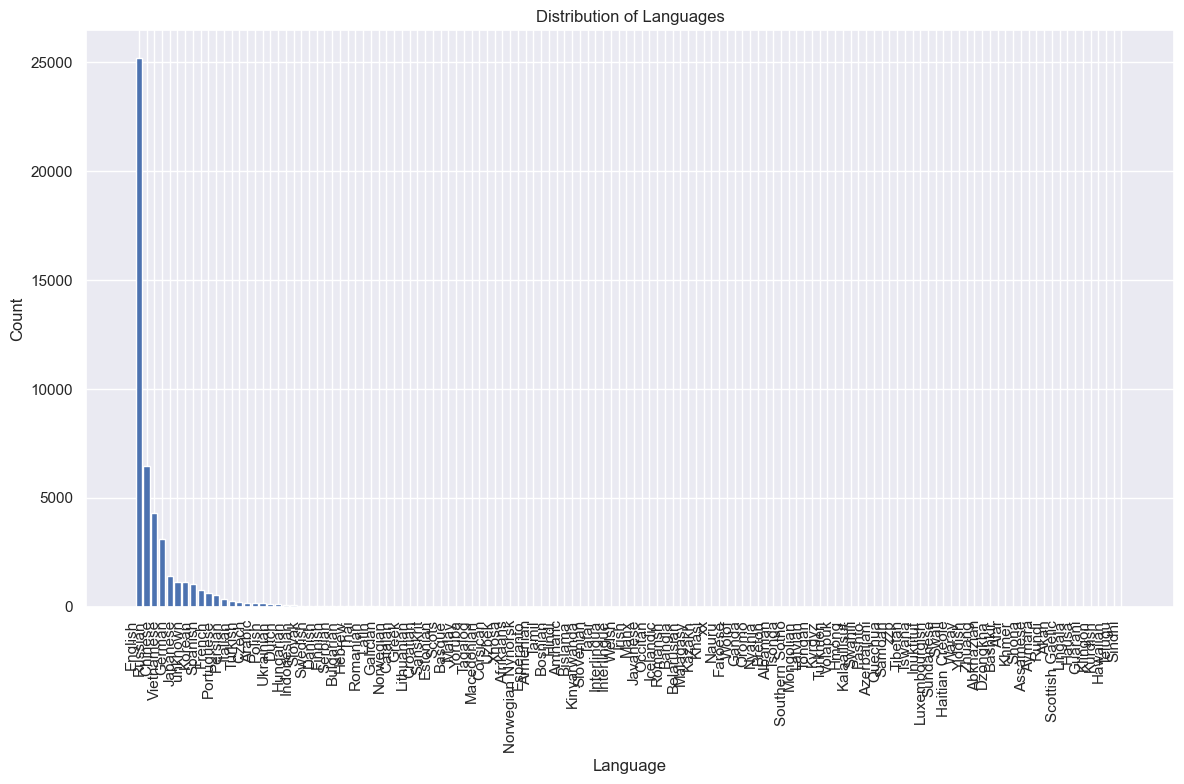

In [24]:
model_df = df_train['language']

counts = model_df.value_counts().reset_index()
counts.columns = ['Language', 'Count']

# Create the bar chart
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plt.bar(counts['Language'], counts['Count'])
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Languages')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Winner Distribution

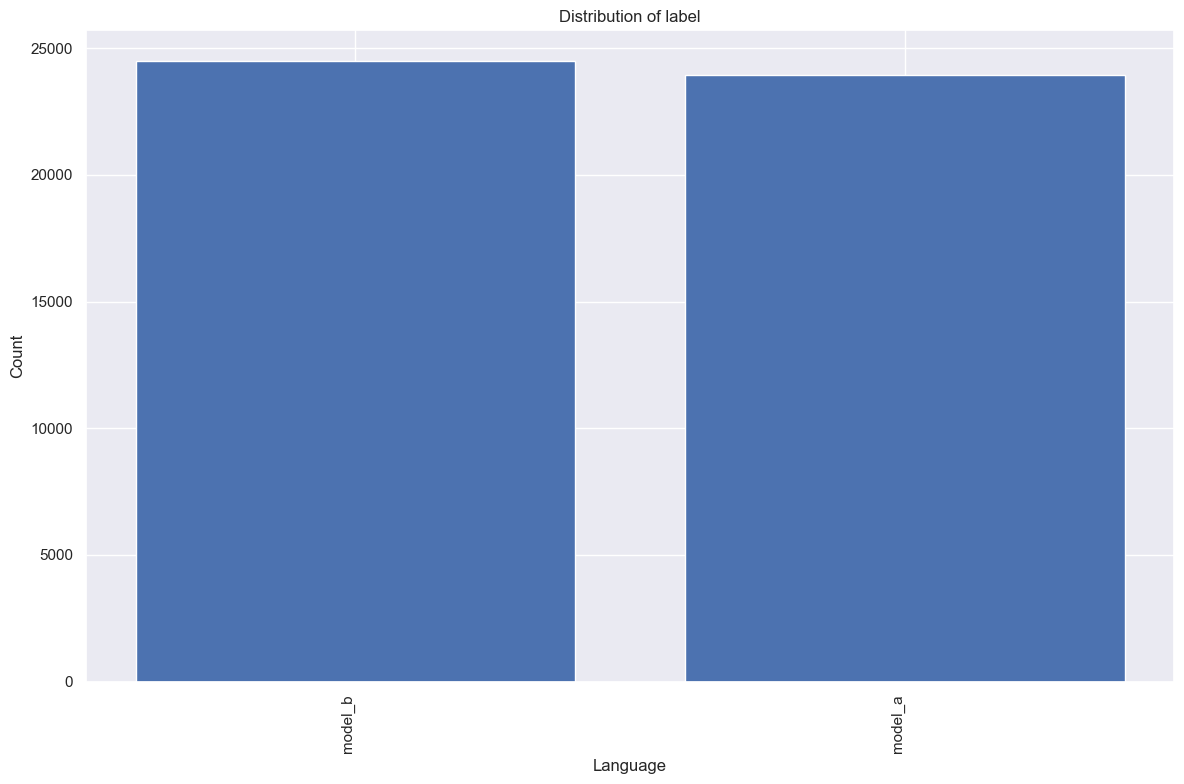

In [25]:
model_df = df_train['winner']

counts = model_df.value_counts().reset_index()
counts.columns = ['Language', 'Count']

# Create the bar chart
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plt.bar(counts['Language'], counts['Count'])
plt.xlabel('Wins')
plt.ylabel('Count')
plt.title('Distribution of label')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

swap a/b to have perfect match between the 2 and avoid any possible position bias ?

### Distribution of length

(todo: do boxplot)

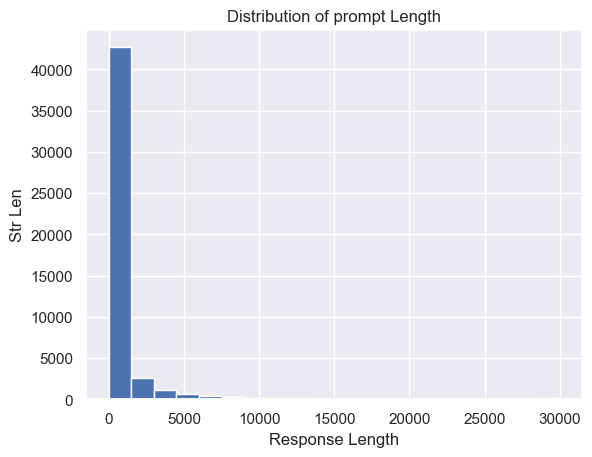

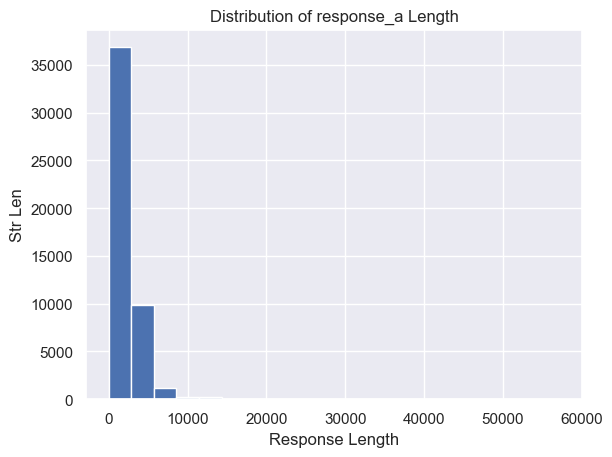

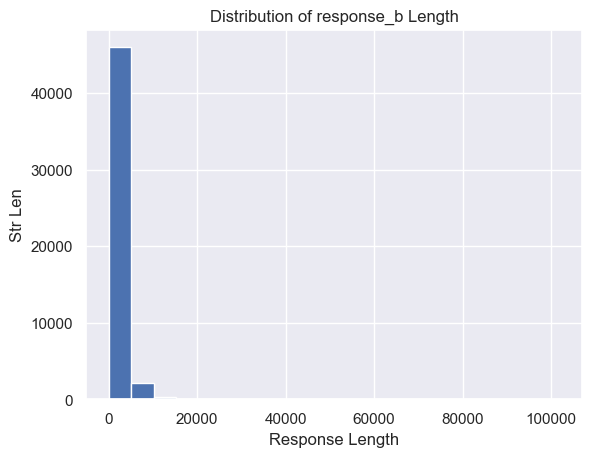

In [26]:
for col in ["prompt", "response_a", "response_b"]:
    plt.hist(df_train[f"{col}_len"], bins=20)
    plt.xlabel('Response Length')
    plt.ylabel('Str Len')
    plt.title(f'Distribution of {col} Length')
    plt.show()

# Feature Engineering

Todo :
- TF/IDF
- Cosine similarity
- Sentiment Analysis
- Bunch of char counting features

In [27]:
df_train, nbfeatures = Utils.extract_all_features(df_train)

In [28]:
nbfeatures

1

# Save CSV

In [29]:
runType = "MINI" if MINI_RUN else "FULL"
original = "original" if ORIGINAL else "custom"


df_train.to_csv(f'../Data/Preprocessed/train_preprocessed_{runType}_{original}.csv', index = False)

# Only English

In [32]:
df_en = df_train[df_train['language'] == 'English']
df_en.to_csv(f'../Data/Preprocessed/train_preprocessed_{runType}_EN.csv', index = False)

In [34]:
df_ru = df_train[df_train['language'] == 'Russian']
df_ru.to_csv(f'../Data/Preprocessed/train_preprocessed_{runType}_RU.csv', index = False)
